# Projet Machine Learning

## Kouyou Essohanam, Abdou Chafin Dean, Aujogue Jean-baptiste

Ce travail se base sur un jeu de donnée de la plateforme open data de l'assurance maladie Française (http://open-data-assurance-maladie.ameli.fr/). Le fichier considéré est la table NB_2016_cip13_age_sexe_reg_spe.CSV téléchargeable sur le lien http://open-data-assurance-maladie.ameli.fr/medicaments/download2.php?Dir_Rep=2016_CIP13, qui recence l'ensemble des médicaments vendus en officines de villes durant l'année 2016 selon un code unique par médicament, et suivant le sexe, la tranche d'âge et la région de résidence des consommateurs. 

Le problème auquel nous nous somme intéressé est la question simple suivante : Etant donné un nouveau médicament, par qui sera-t-il consommé, et en quelles quantités ?

Dans ce travail on considérera une version simplifiée de ce problème, et on cherchera à prédire le mieux possible, pour un médicament donné, le sexe et la tranche d'âge des personnes les plus susceptibles de consommer ce médicament. Pour cela, il est nécessaire de rassembler des attributs pouvant décrire nos médicaments, sur lesquels ont basera notre prédiction. Nous considérerons ici deux ensembles d'attributs pour décrire un médicament, l'ensemble de ses codes de classification ATC d'une part, et l'ensemble de ses principes actifs d'autre part. L'idée naive étant ici que des médicaments ayant le plus de codes en commun, ou partageant le plus de principes actifs, sont en principes similaires et donc destinés à un même groupe de personnes. 

La principale difficulté dans ce travail vient de la bonne sélection des attributs explicatifs, et du fait que tous les attributs utilisés ici sont qualitatifs à énormément de modalités. On présente ce travail en 3 points :

- I. Construction de tables descriptives de médicaments

- II. Construction des sorties à prédire

- III. Mise en place des algorithmes


In [1]:
import numpy as np
np.set_printoptions(threshold=np.nan)
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import roc_auc_score, average_precision_score, silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import cross_val_score, KFold

import time

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# I. Table descriptive des médicaments

On génère dans cette partie une table de description des médicaments apparaissant dans la donnée de départ : chaque ligne correspond à un médicament, et l'ensemble des colonnes est donné par une liste d'attributs pertinents pout décrire chaque médicament. Un médicament est uniquement identifiable par son code CIP_13, et c'est ce code que sera en premier attribut. 

### I.1 Liste des médicaments

On commence par générer le vecteur **T_0** des codes CIP_13 de chaque médicament :

In [105]:
# Import des données en panda DataFrame
data = pd.read_csv('NB_2016_cip13_age_sexe_reg_spe.csv', sep=';', header = 0, encoding = "ISO-8859-1" , na_values="?" ) 

# création d'un numpy array contenant la donnée
X_0 = data.ix[:, :].values
X_0 = X_0[:1800971, :]

In [107]:
data.head()

,CIP13,L_CIP13,AGE,sexe,BEN_REG,PSP_SPE,nbc,REM,BSE,BOITES
0,3400921601916,MONTELUKAST PHR LAB 10 MG CPR 28,20,1,99,1,15,"289,76","414,98",29
1,3400921601916,MONTELUKAST PHR LAB 10 MG CPR 28,20,2,99,1,21,"705,55","915,76",64
2,3400921601916,MONTELUKAST PHR LAB 10 MG CPR 28,60,1,99,1,17,"414,88","615,18",43
3,3400921601916,MONTELUKAST PHR LAB 10 MG CPR 28,60,2,99,1,15,"349,10","529,38",37
4,3400921604177,RIBAVIRINE ZENTIVA 200 MG CPR 28,20,9,99,99,12,"2.048,14","2.048,14",37


In [63]:
med = []
for row in X_0 :
    if row[0] not in med :
        med.append(row[0])

In [66]:
T_0 = list(med)

In [156]:
len(T_0)

12218

## I.2 Table de médicaments par les 5 codes ATC 

### I.2.1 Construction de la table

On forme ici la table **T_1** formée des codes CIP_13 et des classifications ATC de 1 à 5 de nos médicaments, ainsi qu'une table **T_1_bin**  contenant les 5 codes ATC sous une forme binarisée par un One Hot Encodage:

In [124]:
Open_Medic = pd.read_csv('OPEN_MEDIC_2016/OPEN_MEDIC_2016.csv', sep=';', encoding = "ISO-8859-1",  na_values="?" ) 

Z = Open_Medic.ix[:,:].values

In [125]:
Open_Medic[Open_Medic.isnull().any(axis=1)]

,ATC1,l_ATC1,ATC2,L_ATC2,ATC3,L_ATC3,ATC4,L_ATC4,ATC5,L_ATC5,...,L_CIP13,TOP_GEN,GEN_NUM,AGE,sexe,BEN_REG,PSP_SPE,BOITES,REM,BSE


In [105]:
Open_Medic

,ATC1,l_ATC1,ATC2,L_ATC2,ATC3,L_ATC3,ATC4,L_ATC4,ATC5,L_ATC5,...,L_CIP13,TOP_GEN,GEN_NUM,AGE,sexe,BEN_REG,PSP_SPE,BOITES,REM,BSE
0,A,Système digestif et métabolisme,A01,PREPARATIONS STOMATOLOGIQUES,A01A,PREPARATIONS STOMATOLOGIQUES,A01AA,MEDICAMENTS PROPHYLACTIQUES ANTICARIES,A01AA01,SODIUM FLUORURE,...,"ZYMAFLUOR 0,25MG CPR 200",0,0,0,1,5,1,128,"57,02","199,70"
1,A,Système digestif et métabolisme,A01,PREPARATIONS STOMATOLOGIQUES,A01A,PREPARATIONS STOMATOLOGIQUES,A01AA,MEDICAMENTS PROPHYLACTIQUES ANTICARIES,A01AA01,SODIUM FLUORURE,...,"ZYMAFLUOR 0,25MG CPR 200",0,0,0,1,5,12,303,"145,23","480,38"
2,A,Système digestif et métabolisme,A01,PREPARATIONS STOMATOLOGIQUES,A01A,PREPARATIONS STOMATOLOGIQUES,A01AA,MEDICAMENTS PROPHYLACTIQUES ANTICARIES,A01AA01,SODIUM FLUORURE,...,"ZYMAFLUOR 0,25MG CPR 200",0,0,0,1,5,90,72,"30,75","115,36"
3,A,Système digestif et métabolisme,A01,PREPARATIONS STOMATOLOGIQUES,A01A,PREPARATIONS STOMATOLOGIQUES,A01AA,MEDICAMENTS PROPHYLACTIQUES ANTICARIES,A01AA01,SODIUM FLUORURE,...,"ZYMAFLUOR 0,25MG CPR 200",0,0,0,1,5,98,31,"14,30","47,65"
4,A,Système digestif et métabolisme,A01,PREPARATIONS STOMATOLOGIQUES,A01A,PREPARATIONS STOMATOLOGIQUES,A01AA,MEDICAMENTS PROPHYLACTIQUES ANTICARIES,A01AA01,SODIUM FLUORURE,...,"ZYMAFLUOR 0,25MG CPR 200",0,0,0,1,11,1,212,"75,12","255,20"
5,A,Système digestif et métabolisme,A01,PREPARATIONS STOMATOLOGIQUES,A01A,PREPARATIONS STOMATOLOGIQUES,A01AA,MEDICAMENTS PROPHYLACTIQUES ANTICARIES,A01AA01,SODIUM FLUORURE,...,"ZYMAFLUOR 0,25MG CPR 200",0,0,0,1,11,12,792,"290,51","951,75"
6,A,Système digestif et métabolisme,A01,PREPARATIONS STOMATOLOGIQUES,A01A,PREPARATIONS STOMATOLOGIQUES,A01AA,MEDICAMENTS PROPHYLACTIQUES ANTICARIES,A01AA01,SODIUM FLUORURE,...,"ZYMAFLUOR 0,25MG CPR 200",0,0,0,1,11,90,249,"91,25","298,96"
7,A,Système digestif et métabolisme,A01,PREPARATIONS STOMATOLOGIQUES,A01A,PREPARATIONS STOMATOLOGIQUES,A01AA,MEDICAMENTS PROPHYLACTIQUES ANTICARIES,A01AA01,SODIUM FLUORURE,...,"ZYMAFLUOR 0,25MG CPR 200",0,0,0,1,11,98,174,"62,30","208,86"
8,A,Système digestif et métabolisme,A01,PREPARATIONS STOMATOLOGIQUES,A01A,PREPARATIONS STOMATOLOGIQUES,A01AA,MEDICAMENTS PROPHYLACTIQUES ANTICARIES,A01AA01,SODIUM FLUORURE,...,"ZYMAFLUOR 0,25MG CPR 200",0,0,0,1,11,99,12,"4,32","14,40"
9,A,Système digestif et métabolisme,A01,PREPARATIONS STOMATOLOGIQUES,A01A,PREPARATIONS STOMATOLOGIQUES,A01AA,MEDICAMENTS PROPHYLACTIQUES ANTICARIES,A01AA01,SODIUM FLUORURE,...,"ZYMAFLUOR 0,25MG CPR 200",0,0,0,1,24,1,72,"27,42","86,40"


In [141]:
T_1_temp = []
T_0_temp = []
compteur = 0
for ligne in Z :
    if ligne[10] not in T_0_temp :
        T_1_temp.append([ligne[10], ligne[0], ligne[2], ligne[4], ligne[6], ligne[8]])
        T_0_temp.append(ligne[10])
        compteur += 1
        if compteur % 1000 == 0 :
            print(compteur)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000


In [142]:
len(T_1_temp)

12219

In [143]:
T_1_list = []
for code_CIP_13 in T_0 :
    for liste in T_1_temp :
        if liste[0] == code_CIP_13 :
            T_1_list.append(liste)
            break

In [144]:
T_1 = np.asarray(T_1_list)

In [145]:
T_1.shape

(12218, 6)

Il est nécessaire de numériser les entrées de cette table : Pour cela on procède ici naivement, en remplacant chaque valeur dans les colonnes contenant des lettres par des entier, puis en binarisant ces colonnes selon la méthode OneHotEncoder de scikit-learn. Pour une petite discussion sympa sur le traitement des attributs catégoriciels on peut voir :

- https://blog.myyellowroad.com/using-categorical-data-in-machine-learning-with-python-from-dummy-variables-to-deep-category-66041f734512

- https://blog.myyellowroad.com/using-categorical-data-in-machine-learning-with-python-from-dummy-variables-to-deep-category-42fd0a43b009

Les colonnes à traiter comme catégoricielles sont ici les colonnes des 5 codes ATC, la première colonne contenant le code CIP_13 est donc à sauter :

In [146]:
# On numérise nos 5 colonnes
col_cat = [1, 2, 3, 4, 5]

T_1_cat = np.copy(T_1[:, col_cat])
for col_id in range(len(col_cat)):
    unique_val, val_idx = np.unique(T_1_cat[:, col_id], return_inverse=True)
    T_1_cat[:, col_id] = val_idx
    print(unique_val)

['A' 'B' 'C' 'D' 'G' 'H' 'J' 'L' 'M' 'N' 'P' 'R' 'S' 'V']
['A01' 'A02' 'A03' 'A04' 'A05' 'A06' 'A07' 'A09' 'A10' 'A11' 'A12' 'A14'
 'A16' 'B01' 'B02' 'B03' 'B05' 'C01' 'C02' 'C03' 'C04' 'C05' 'C07' 'C08'
 'C09' 'C10' 'D01' 'D02' 'D05' 'D06' 'D07' 'D08' 'D10' 'D11' 'G01' 'G02'
 'G03' 'G04' 'H01' 'H02' 'H03' 'H04' 'H05' 'J01' 'J02' 'J04' 'J05' 'J06'
 'J07' 'L01' 'L02' 'L03' 'L04' 'M01' 'M02' 'M03' 'M04' 'M05' 'M09' 'N01'
 'N02' 'N03' 'N04' 'N05' 'N06' 'N07' 'P01' 'P02' 'P03' 'R01' 'R03' 'R05'
 'R06' 'R07' 'S01' 'S02' 'V01' 'V03' 'V04' 'V06' 'V07' 'V08']
['A01A' 'A02A' 'A02B' 'A02X' 'A03A' 'A03B' 'A03E' 'A03F' 'A04A' 'A05A'
 'A05B' 'A06A' 'A07A' 'A07D' 'A07E' 'A07X' 'A09A' 'A10A' 'A10B' 'A11C'
 'A11D' 'A11G' 'A11H' 'A12A' 'A12B' 'A12C' 'A14A' 'A16A' 'B01A' 'B02A'
 'B02B' 'B03A' 'B03B' 'B03X' 'B05B' 'B05X' 'C01A' 'C01B' 'C01C' 'C01D'
 'C01E' 'C02A' 'C02C' 'C02D' 'C02L' 'C03A' 'C03B' 'C03C' 'C03D' 'C03E'
 'C03X' 'C04A' 'C05A' 'C05B' 'C07A' 'C07B' 'C07C' 'C07D' 'C07F' 'C08C'
 'C08D' 'C08G' '

In [147]:
from sklearn.preprocessing import OneHotEncoder
encoder  =  OneHotEncoder()
encoder_fit = encoder.fit_transform(T_1_cat)
T_1_bin = encoder_fit.toarray()


print(encoder.n_values_) 
print(encoder.feature_indices_)
print(T_1_bin.shape)

[  14   82  196  440 1142]
[   0   14   96  292  732 1874]
(12218, 1874)


In [269]:
np.savetxt("T_1_bin.csv", T_1_bin , delimiter=",")

On passe la table binaire en panda pour un meilleur rendu lors de l'affichage :

In [38]:
T_1_bin_pd = pd.DataFrame(T_1_bin)

In [39]:
T_1_bin_pd.astype(int).head()

,0,1,2,3,4,5,6,7,8,9,...,1864,1865,1866,1867,1868,1869,1870,1871,1872,1873
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


La table T_1_bin des médicaments avec description binarisée des les 5 codes ATC possède donc 1874 attributs. 

### I.2.2 Réduction de dimension

On commence par une réduction de dimension par décomposition en valeurs singulières. On essaie avec 50 vecteurs puis avec 20 vecteurs.

In [62]:
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix

svd_50 = TruncatedSVD(n_components=50, n_iter=10, random_state=42)
T_1_svd_50 = svd_50.fit_transform(T_1_bin)
print(svd_50.explained_variance_ratio_[:5])

[ 0.06718493  0.0478816   0.04607486  0.03186889  0.03419482]


In [18]:
np.savetxt("T_1_svd_50.csv", T_1_svd_50 , delimiter=",")

In [40]:
T_1_svd_50_pd = pd.DataFrame(T_1_svd_50)

In [44]:
T_1_svd_50_pd

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,1.456777e-15,4.177474e-16,-4.953488e-16,1.003712e+00,-2.631321e-13,7.898411e-13,-1.409903e-11,1.024560e-11,4.992481e-11,-1.272801e-10,...,-0.000317,-0.000018,6.410159e-06,0.000084,-0.000111,-0.000035,0.000104,-0.000022,0.000307,0.000345
1,2.572328e-18,-1.815193e-15,1.961889e-15,1.327255e-13,-1.095530e-14,1.176132e-11,3.189230e-12,5.791266e-11,-5.928694e-11,4.777213e-10,...,-0.000086,0.000004,-2.541592e-05,-0.000119,0.000113,0.000420,-0.000183,-0.000645,-0.001893,-0.000027
2,3.133280e-16,-8.054684e-16,1.839586e+00,-1.658954e-13,-2.610091e-13,-8.778482e-01,-7.399252e-12,-1.616866e-11,-5.491603e-11,1.896555e-10,...,-0.000018,-0.000005,1.439480e-03,-0.000127,0.000242,0.000550,-0.013476,-0.000323,-0.001139,-0.000562
3,7.632297e-16,-3.190836e-14,-4.512653e-13,-6.269552e-13,-3.476467e-11,-3.736031e-10,-3.334405e-10,2.215609e-09,6.966903e-09,-1.540900e-08,...,0.002363,0.001392,-6.006683e-04,0.258381,-0.006592,0.012642,0.024298,-0.057746,-0.008259,0.091398
4,3.216502e-16,-1.420595e-15,1.839586e+00,-1.623324e-13,-2.602238e-13,-8.778482e-01,-7.395974e-12,-1.616793e-11,-5.491637e-11,1.896560e-10,...,-0.000018,-0.000005,1.439480e-03,-0.000127,0.000242,0.000550,-0.013476,-0.000323,-0.001139,-0.000562
5,3.215412e-16,-1.421692e-15,1.839586e+00,-1.669273e-13,-2.617014e-13,-8.778482e-01,-7.400181e-12,-1.616403e-11,-5.491839e-11,1.896550e-10,...,-0.000018,-0.000005,1.439480e-03,-0.000127,0.000242,0.000550,-0.013476,-0.000323,-0.001139,-0.000562
6,-5.392650e-17,1.053014e-16,-7.505539e-16,6.694411e-15,-8.180051e-14,-1.933019e-13,-2.792941e-12,-1.867897e-12,1.088602e-11,5.687484e-12,...,0.000002,0.000012,-8.720062e-07,-0.000002,-0.000016,-0.000044,-0.000024,-0.000062,-0.000084,0.000068
7,8.261640e-01,1.717632e-15,8.692964e-15,-3.000215e-13,1.771454e-01,-7.731544e-12,2.451977e-01,-8.992658e-11,-8.837637e-12,-1.490028e-04,...,0.000103,1.035035,-8.114328e-05,-0.000201,0.000176,-0.671596,-0.007178,0.020448,-0.461998,0.081287
8,8.261640e-01,1.717516e-15,8.692731e-15,-3.000067e-13,1.771454e-01,-7.730970e-12,2.451977e-01,-8.993032e-11,-8.839190e-12,-1.490028e-04,...,0.000103,1.035035,-8.114328e-05,-0.000201,0.000176,-0.671596,-0.007178,0.020448,-0.461998,0.081287
9,-8.447629e-17,9.228595e-16,2.772341e-14,2.098652e-13,2.885653e-12,4.054215e-11,1.478836e-10,1.103499e-10,-1.044239e-09,2.682574e-09,...,-0.000425,-0.000061,-1.150642e-04,0.000469,0.001263,0.001254,-0.003589,0.001099,-0.004780,-0.006873


In [19]:
svd_20 = TruncatedSVD(n_components=20, n_iter=10, random_state=42)
T_1_svd_20 = svd_20.fit_transform(T_1_bin)

In [20]:
np.savetxt("T_1_svd_20.csv", T_1_svd_20 , delimiter=",")

On a également essayé la réduction de dimension avec une normalisation suivie d'une ACP mais les résultat d'apprentissages sont médiocres dans ce cas, on ne présente donc pas cette solution.

## I.3 Table des médicaments par les principes actifs

### I.3.1 Construction de la table

On crée tout d'abord une table **T_2** incluant le code CIS de chaque médicament :

On charge le fichier de présentations, accessible sur http://agence-prd.ansm.sante.fr/php/ecodex/telecharger/telecharger.php : Fichier contenant toutes les présentations des spécialités du Répertoire des Spécialités Pharmaceutiques. Les champs d'information sont le code CIS de la spécialité à laquelle la présentation appartient, le code CIP à 7 chiffres de la présentation, le libellé de la présentation, le statut administratif de la présentation, l'état de commercialisation de la présentation tel que déclaré par le titulaire de l'AMM, la date de la déclaration et le code CIP à 13 chiffres de la présentation.

De tout ceci on prend juste le code CIS, le reste ne semble pas très intéressant :

In [237]:
#chargement des donnees descriptives des medicaments
tete_cis_cip = ["Code CIS", "CIP_7", "libellé présentation", "statut administratif", "état commercialisation", "date déclaration", "CIP_13"]
data_cis_cip= pd.read_csv('CIS_CIP.txt',sep='\t',index_col=False ,header=None,names = tete_cis_cip,encoding = "ISO-8859-1")
cis_cip = data_cis_cip.ix[:, :].values
print(cis_cip.shape)

(134323, 7)


In [238]:
data_cis_cip

,Code CIS,CIP_7,libellé présentation,statut administratif,état commercialisation,date déclaration,CIP_13
0,60000318,2166845.0,plaquette(s) thermoformée(s) polyamide alumini...,Présentation active,Déclaration de commercialisation non communiquée,,3.400922e+12
1,60000318,2166851.0,plaquette(s) thermoformée(s) polyamide alumini...,Présentation active,Déclaration de commercialisation non communiquée,,3.400922e+12
2,60000318,2166868.0,plaquette(s) thermoformée(s) polyamide alumini...,Présentation active,Déclaration de commercialisation non communiquée,,3.400922e+12
3,60000318,2166874.0,plaquette(s) thermoformée(s) polyamide alumini...,Présentation active,Déclaration de commercialisation non communiquée,,3.400922e+12
4,60000318,2166880.0,plaquette(s) thermoformée(s) polyamide alumini...,Présentation active,Déclaration de commercialisation non communiquée,,3.400922e+12
5,60000318,2166897.0,plaquette(s) thermoformée(s) polyamide alumini...,Présentation active,Déclaration de commercialisation non communiquée,,3.400922e+12
6,60000318,2166905.0,plaquette(s) thermoformée(s) polyamide alumini...,Présentation active,Déclaration de commercialisation non communiquée,,3.400922e+12
7,60000318,2166911.0,plaquette(s) thermoformée(s) polyamide alumini...,Présentation active,Déclaration de commercialisation non communiquée,,3.400922e+12
8,60000318,2166928.0,plaquette(s) thermoformée(s) polyamide alumini...,Présentation active,Déclaration de commercialisation non communiquée,,3.400922e+12
9,60000318,5807109.0,plaquette(s) thermoformée(s) polyamide alumini...,Présentation active,Déclaration de commercialisation non communiquée,,3.400958e+12


In [239]:
T_2_temp = []
for code_CIP_13 in T_0 :
    for row in cis_cip :
        val = 'nan'
        if row[6] == code_CIP_13:
            val = row[0]
            break
    T_2_temp.append(val)

In [240]:
T_2_temp_np = np.asarray(T_2_temp).reshape(-1,1)

In [241]:
T_2 = np.concatenate((T_1, T_2_temp_np), axis=1 )

In [242]:
T_2.shape

(12218, 7)

In [243]:
np.unique(T_2[:, 6]).shape[0]

8753

On compte le nombre de codes CIS présents dans notre jeu de 12218 médicaments : Il y en a 8753. Chaque code CIS correspond à la dénomination d'un médicament fabriqué industriellement, et chaque code CIP_13 correspond en réalité à une présentation de ce même médicament. 

**Remarque ** : Deux médicaments avec le même code sont probablement les mêmes médicaments mais avec des dosages différents, ce qui a un impact sur la tranche d'âge des consommateurs (et probablement le sexe aussi). Mais cet impact est 'inversé' au sens où deux médicaments avec même CIS donnent probablement des résultats opposés de prédiction d'âge et de sexe. On n'est pour l'instant pas sûr de la méthode a suivre pour incorporer ce code pour que l'apprentissage se fasse correctement, ie de façon à ce que l'algorithme observe que "même CIS => âge et sexe des consommants opposés".

L'objectif est maintenant de construire, à partir des codes CIS, une table binaire **T_3_bin** décrivant chaque médicament par un vecteur de 0 et de 1 présentant l'ensemble des principes actifs contenus. 


On charge le fichier de composition, téléchargeable sur http://agence-prd.ansm.sante.fr/php/ecodex/telecharger/telecharger.php : Fichier contenant la composition qualitative et quantitative en substances actives et fractions thérapeutiques (telle que figurant dans le RCP) de toutes les spécialités du Répertoire des Spécialités Pharmaceutiques. Les champs d'information sont le code CIS, la désignation de l'élément pharmaceutique décrit, le code de la substance, la dénomination de la substance, le dosage de la substance, la référence de ce dosage, la nature du composant (principe actif ou fraction thérapeutique) et un numéro permettant de lier, le cas échéant, substances actives et fractions thérapeutiques.

On cherche à intégrer en priorité les substances présentes dans chaque médicament, et on aimerait également intégrer le dosage de ces substances, en prennant garde au fait que la quantification est relative à une gélule, un comprimé, une 'dose', un volume, un poids... une référence qui n'est pas la même pour tous les médicaments. Pour en savoir plus la dessus on commence par voir quelles sont les désignations possibles de nos médicaments :

In [55]:
#chargement des donnees descriptives des medicaments
tete_compo = ["Code CIS", "désignation", "code substance", "dénomination substance", "dosage substance", "référence de ce dosage", "nature composant", "Numero liant SA et FT"]
data_compo= pd.read_csv('COMPO.txt',sep='\t',index_col=False ,header=None,names = tete_compo ,encoding = "ISO-8859-1")
compo = data_compo.ix[:, :].values
print(compo.shape)
 

(56604, 8)


In [56]:
data_compo

,Code CIS,désignation,code substance,dénomination substance,dosage substance,référence de ce dosage,nature composant,Numero liant SA et FT
0,60000318,comprimé,819,INDAPAMIDE,"2,5 mg",un comprimé,SA,2.0
1,60000318,comprimé,9586,PÉRINDOPRIL TERT-BUTYLAMINE,8 mg,un comprimé,SA,1.0
2,60000318,comprimé,52431,PÉRINDOPRIL,"6,676 mg",un comprimé,FT,1.0
3,60001288,comprimé,468,CODÉINE (PHOSPHATE DE) SESQUIHYDRATÉ,15 mg,un comprimé,SA,1.0
4,60001288,comprimé,2202,PARACÉTAMOL,250 mg,un comprimé,SA,3.0
5,60001288,comprimé,2489,MÉTAMIZOLE SODIQUE,250 mg,un comprimé,SA,4.0
6,60001943,plante(s),3164,ALCHÉMILLE VULGAIRE,25 g,100 g,SA,1.0
7,60001943,plante(s),5872,MARRON D'INDE,25 g,100 g,SA,3.0
8,60001943,plante(s),7203,VIBURNUM,10 g,100 g,SA,4.0
9,60001943,plante(s),7335,VIGNE ROUGE,25 g,100 g,SA,5.0


In [245]:
T_3_temp = []
for i, row in enumerate(T_2) :
    des = " "
    substances = []
    for ligne in compo :
        if ligne[0] == row[6] :
            des = ligne[1]
            substances.append([ligne[2], ligne[4], ligne[6], ligne[7]])
    T_3_temp.append([des, substances])
    if i % 1000 == 0 :
        print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000


In [246]:
T_3_temp_copie = list(T_3_temp)

In [247]:
Des = [paire[0] for paire in T_3_temp]

In [251]:
len(set(Des))

72

Notre fichier de médicaments contient 72 désignation différentes !! Des pilules, gels, champooings et autres.. Il est donc très difficile de donner un 'dosage' pour des désignations si différentes. On se concentre donc uniquement sur la présence /l'abscence de chaque principe actif dans nos médicaments. On extraie alors l'ensemble des substances présentes dans au moins un médicament de notre base (pour lesquelles on garde seulement le code de chaque substance, soit une valeur entre 1 et 100.000) :

In [252]:
Substances_1 = [paire[1] for paire in T_3_temp]
Substances = []
for colec in Substances_1 :
    for quadruplet in colec :
        if quadruplet[0] not in Substances :
            Substances.append(quadruplet[0])

In [253]:
len(Substances)

1645

On dénombre ainsi 1645 Substances différentes, soit autant d'attributs binaires supplémentaires pour décrire chaque médicament. On génère la table binaire de chaque médicament et des ces attributs binaires uniquement :

In [258]:
T_3_bin = np.zeros((len(T_0), len(Substances)))

In [263]:
for i, paire in enumerate(T_3_temp) :
    for j, sub in enumerate(Substances) :
        for quadruplet in paire[1] :
            if quadruplet[0] == sub :
                T_3_bin[i, j] = 1  
                break

In [265]:
T_3_bin.shape

(12218, 1645)

In [267]:
np.savetxt("T_3_bin.csv", T_3_bin , delimiter=",")

In [35]:
T_3_bin_pd = pd.DataFrame(T_3_bin)

In [37]:
T_3_bin_pd.astype(int).head()

,0,1,2,3,4,5,6,7,8,9,...,1635,1636,1637,1638,1639,1640,1641,1642,1643,1644
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Attention le stockage de T_3_bin pèse très lourd : 500 Mo environ

### I.3.2 Réduction de dimension

On fait une réduction de dimension de cette table binaire par décomposition en valeurs singulières commes pour la table T_1_bin :

In [12]:
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix

svd_50 = TruncatedSVD(n_components=50, n_iter=10, random_state=42)
T_3_svd_50 = svd_50.fit_transform(T_3_bin)
print(svd_50.explained_variance_ratio_)

[ 0.04428215  0.03313944  0.02582173  0.0177031   0.01609497  0.0136743
  0.01336938  0.01137031  0.0110201   0.00993651  0.00954988  0.00951482
  0.00938097  0.00902254  0.00868123  0.00832962  0.00820815  0.00777235
  0.00726653  0.00711823  0.00695913  0.00698565  0.00659542  0.0063205
  0.00617256  0.00603698  0.00601117  0.00605527  0.00591254  0.0058087
  0.00568224  0.00555828  0.00540614  0.00530798  0.00530118  0.00526492
  0.00526685  0.00526819  0.00515477  0.00511219  0.00507435  0.00495457
  0.00483199  0.00478521  0.00471543  0.00478438  0.00473788  0.00468601
  0.00463801  0.00438811]


In [14]:
np.savetxt("T_3_svd_50.csv", T_3_svd_50 , delimiter=",")

In [45]:
T_3_svd_50_pd = pd.DataFrame(T_3_svd_50)

In [46]:
T_3_svd_50_pd

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,3.754530e-15,-9.618559e-17,8.146414e-14,2.895398e-12,7.169921e-12,-4.954179e-11,1.307720e-11,1.628126e-10,-2.100417e-10,3.892898e-10,...,2.152222e-07,2.143392e-07,1.774165e-07,2.398722e-06,-3.270007e-07,-1.450524e-07,-8.216049e-08,-5.155452e-08,-1.095485e-06,2.561070e-06
1,-8.392243e-18,6.979045e-17,-1.718551e-15,-1.206408e-18,2.252716e-16,-4.298347e-16,-1.142793e-17,-1.167737e-15,-3.215297e-15,8.513203e-16,...,1.731240e-15,3.542728e-16,7.219405e-16,1.806807e-16,-4.780598e-15,1.187330e-15,-3.305280e-17,-1.119379e-16,3.675229e-16,-9.395785e-17
2,-9.362212e-16,5.886568e-15,-1.515257e-13,-9.142769e-12,-5.677216e-11,2.451426e-10,-1.829914e-11,-1.993938e-09,8.323999e-09,1.409998e+00,...,-5.108096e-07,-6.204789e-08,3.216307e-07,1.049598e-06,9.232569e-08,-3.663478e-07,-7.288910e-08,2.602082e-07,6.659490e-08,-1.263677e-07
3,2.618688e-18,-1.938345e-17,3.699459e-16,5.004307e-16,-4.764938e-15,1.274983e-14,-2.849352e-15,2.289860e-14,1.205281e-14,4.310321e-14,...,1.887202e-11,-4.607639e-11,1.999153e-11,1.883947e-10,-1.063098e-10,-8.414265e-11,1.188572e-10,-1.546446e-10,1.166326e-10,2.274752e-10
4,-9.702829e-16,6.150936e-15,-1.571280e-13,-9.148484e-12,-5.676881e-11,2.451413e-10,-1.829991e-11,-1.993938e-09,8.324000e-09,1.409998e+00,...,-5.108096e-07,-6.204789e-08,3.216307e-07,1.049598e-06,9.232568e-08,-3.663478e-07,-7.288910e-08,2.602082e-07,6.659490e-08,-1.263677e-07
5,-9.703211e-16,6.151095e-15,-1.571334e-13,-9.148152e-12,-5.676888e-11,2.451392e-10,-1.829528e-11,-1.993937e-09,8.324001e-09,1.409998e+00,...,-5.108096e-07,-6.204789e-08,3.216307e-07,1.049598e-06,9.232569e-08,-3.663478e-07,-7.288910e-08,2.602082e-07,6.659490e-08,-1.263677e-07
6,-2.793438e-14,2.845470e-13,4.456685e-13,5.734250e-10,-2.124287e-11,-1.524180e-09,-1.082365e-09,-4.101048e-08,4.876595e-08,-4.772178e-08,...,-8.009063e-05,1.279004e-04,-2.120778e-04,-1.543353e-05,1.043509e-05,1.980292e-04,9.549481e-05,3.119250e-05,2.781204e-04,-8.783103e-05
7,-8.592104e-19,1.764750e-18,1.238493e-16,-1.064040e-15,-2.313938e-14,2.894679e-14,3.321736e-14,-6.427257e-13,1.432952e-12,-3.790972e-12,...,5.003419e-10,1.460441e-09,-5.443799e-10,-4.324920e-09,1.688441e-09,5.750973e-10,-2.305790e-09,3.601570e-10,-7.249134e-10,4.609731e-09
8,-8.521645e-19,1.762142e-18,1.205332e-16,-8.863963e-16,-2.367203e-14,2.940184e-14,3.385707e-14,-6.327843e-13,1.440092e-12,-3.797287e-12,...,5.003428e-10,1.460441e-09,-5.443801e-10,-4.324922e-09,1.688448e-09,5.750950e-10,-2.305790e-09,3.601571e-10,-7.249135e-10,4.609731e-09
9,-8.433897e-21,4.323343e-20,-2.061301e-18,-1.834621e-18,-1.161738e-16,-3.183335e-16,6.292301e-17,2.498458e-15,-4.976982e-15,-2.254610e-14,...,1.561626e-16,-1.430206e-16,4.466458e-16,-2.649519e-15,6.236494e-16,3.554871e-16,6.158021e-17,3.207751e-17,1.657614e-16,8.276327e-17


In [13]:
svd_20 = TruncatedSVD(n_components=20, n_iter=10, random_state=42)
T_3_svd_20 = svd_20.fit_transform(T_3_bin)

In [15]:
np.savetxt("T_3_svd_20.csv", T_3_svd_20 , delimiter=",")

## I.4 Rassemblement des tables

On fusionne ici les tables construites, c'est à dire, celle issues des codes ATC et celle venant des principes actifs. On a deux possibilités : soit on prend les tables des 20 ou 50 premières composantes singulières que l'on fusionne, soit on fusionne les tables binaires complètes T_1_bin et T_3_bin pour ensuite effectuer une réduction de dimension. On applique chacune des possibilités ici :

In [21]:
T_4_svd_20 = np.concatenate((T_1_svd_20, T_3_svd_20 ), axis = 1)

In [22]:
T_4_svd_50 = np.concatenate((T_1_svd_50, T_3_svd_50 ), axis = 1)

In [23]:
T_5_temp = np.concatenate((T_1_bin, T_3_bin ), axis = 1)

In [24]:
svd = TruncatedSVD(n_components=50, n_iter=10, random_state=42)
T_5 = svd.fit_transform(T_5_temp)

# II. Table des valeurs à prédire

On se propose de prédire deux sorties, toute deux qualitatives : le sexe le plus probable d'un consommateur aléatoire d'un médicament donné, qui possède 2 modalités, et la tranche d'âge, qui en possède 3. On commence par remplacer dans notre table X_0 la colonne des codes CIP_13 par des valeurs de 1 à 12218, ceci de façon à simplifier fortement les calculs qui suivent.

In [ ]:
X_num = np.copy(X_0)

for row in X_num :
    for i in range(len(T_0)) :
        if row[0] == T_0[i] :
            row[0] = i+1
            break

## II.1 Sortie 'sexe'

On génère une table donnant, pour chaque médicament, le nombre de boites vendues aux consommateurs de chaque sexe (plus le sexe inconnu). On stocke ensuite cette table au format CSV, puis on génère un vecteur de sortie binaire, qui prend les valeurs 0 ou 1 suivant si un médicament est plus consommé par les hommes ou par les femmes :

In [215]:
Y_nbre_boites_par_sexe = np.zeros((len(T_0), 3))

In [216]:
#Conso médicaments par sexe
modalites_sexe=[1, 2, 9]

for row in X_num :
    for i, sexe in enumerate(modalites_sexe) :
        if row[3] == sexe :
            Y_nbre_boites_par_sexe[row[0]-1, i] += row[9]

In [202]:
np.savetxt("Y_nbre_boites_par_sexe.csv", Y_nbre_boites_par_sexe , delimiter=",")

In [8]:
Y_nbre_boites_par_sexe_bin = np.arange(Y_nbre_boites_par_sexe.shape[0]).reshape(-1,1)

for i, row in enumerate(Y_nbre_boites_par_sexe[:, [0,1]]) :
    if row[0] == np.amax(row) :
        Y_nbre_boites_par_sexe_bin[i] = 0
    else :
        Y_nbre_boites_par_sexe_bin[i] = 1

In [9]:
Y_nbre_boites_par_sexe_bin[:5,:]

array([[0],
       [1],
       [0],
       [1],
       [0]])

En plus du vecteur de sortie binaire créé, on veut crée une sortie **probabiliste** donnant pour chaque sexe sa probabilité empirique pour un consommateur aléatoire d'un médicament donné. L'idée est que, plutôt que d'entrainer un algorithmes à prédire 0 ou 1 sur la base du vecteur binaire construit, on cherche à entrainer un algorithme à estimer la probabilité d'avoir 0 (et donc un moins la probabilité d'avoir 1), soit une valeur entre 0 et 1. Un classifieur déterministe serait alors naturellement obtenu en classifiant par 0 ou 1 selon le seuil 0.5. 

In [230]:
Y_nbre_boites_par_sexe_proba = np.arange(Y_nbre_boites_par_sexe.shape[0], dtype = np.float64).reshape(-1,1)

for i, row in enumerate(Y_nbre_boites_par_sexe[:, [0,1]]) :
    if row[0] + row[1] != 0 :
        Y_nbre_boites_par_sexe_proba[i] = row[0] /(row[0] + row[1])
    else :
        Y_nbre_boites_par_sexe_proba[i] = 0.5 #ce choix de 0.5 est tout à fait discutable

In [231]:
Y_nbre_boites_par_sexe_proba[:5,:]

array([[ 0.41618497],
       [ 0.5       ],
       [ 0.40881262],
       [ 0.51612903],
       [ 0.23684529]])

## II.2 Sortie 'âge'

On génère une table qui à chaque médicament donne un quadruplet, formé des nombres de boites vendues à chaque tranche d'âge (plus l'âge inconnu). Après avoir sauvé cette table dans un fichier CSV, on génère la table qui à un médicament associe un triplet binaire, ie un triplet de la forme (0,1,0) par exemple, où la position du 1 doit correspondre à la tranche d'âge la plus consommatrice de ce médicament :

In [196]:
Y_nbre_boites_par_age = np.zeros((len(T_0), 4))

In [197]:
#Conso médicaments par age
modalites_age=[0, 20, 60, 99]

for row in X_num :
    for i, age in enumerate(modalites_age) :
        if row[2] == age :
            Y_nbre_boites_par_age[row[0]-1, i] += row[9]
            break

In [201]:
np.savetxt("Y_nbre_boites_par_age.csv", Y_nbre_boites_par_age , delimiter=",")

In [5]:
Y_nbre_boites_par_age_bin = np.copy(Y_nbre_boites_par_age[:,[0,1,2] ])

for row in Y_nbre_boites_par_age_bin :
    for i in range(3) :
        if row[i] == np.amax(row) :
            row[i] = 1
            for j in range(i+1, 3) :
                row[j] = 0
            break
        else :
            row[i] = 0

In [6]:
Y_nbre_boites_par_age_bin[:10,:]

array([[ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 1.,  0.,  0.]])

On génère enfin également un vecteur de sortie à trois modalités 1, 2 et 3 possibles pour chaque coefficient, suivant la tranche d'âge :

In [89]:
Y_nbre_boites_par_age_3 = [ [1 + i for i in [0,1,2] if Y_nbre_boites_par_age_bin[j, i] == 1 ]  for j in range(Y_nbre_boites_par_age_bin.shape[0])]

In [91]:
Y_nbre_boites_par_age_3 = [i[0] for i in Y_nbre_boites_par_age_3 ]

# III. Algorithmes d'apprentissage

## III.1 Prédiction du sexe

### III.1.1 Prédiction du sexe sur la base des codes ATC

On effectue une prédiction du sexe prédominant parmi les consommateurs d'un médicament donné, sur la base des codes ATC de 1 à 5 de chaque médicament :

In [110]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import roc_auc_score, average_precision_score
import time
%matplotlib inline
from matplotlib.ticker import FuncFormatter
import seaborn as sns

    
def runClassifiers_bin(clfs, X, Y, graphe = True) :
    kf = KFold(n_splits=10, shuffle=True, random_state=0)
    
    
    cv_acc = {}
    cv_auc = {}
    t0 = {}
    t1 = {}
    
    for i in clfs:
        t0[i] = time.time()
        clf = clfs[i] #clf correspond au ième algorithme dans le dictionnaire clfs.
        cv_acc[i] = cross_val_score(clf, X, Y, cv=kf, scoring = 'accuracy' )                       #
        cv_auc[i] = cross_val_score(clf, X, Y, cv=kf, scoring='roc_auc')     # voir http://scikit-learn.org/stable/modules/model_evaluation.html
        t1[i] = time.time()
        print("estimations par validation croisée 10 fold de {0} :".format(i))
        print("Taux biens classés = {0:.3f} +/- {1:.3f}".format(np.mean(cv_acc[i]), np.std(cv_acc[i])))
        print("AUC = {0:.3f} +/- {1:.3f}".format(np.mean(cv_auc[i]), np.std(cv_auc[i])))
        print("Temps d'exécution = {0:.3f} secondes".format(t1[i] - t0[i]))
        print('\n')

    if graphe:
        cv_acc_df = pd.DataFrame.from_dict(cv_acc)

        plt.figure(figsize=(30, 8))
        ax1 = plt.subplot(121)
        ax1 = sns.boxplot(data = cv_acc_df, palette="Set3", orient = "h")
        ax1.tick_params(labelsize = 25, colors='darkblue')
        ax1.set_title("Taux de biens classés par validation croisée 10-folds", fontsize = 30)
        plt.show()

In [111]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
# from id3 import Id3Estimator

Liste = {
'Naive_Bayes_Gaussien': GaussianNB(),  # Naive Bayes classifier http://scikit-learn.org/stable/modules/naive_bayes.html
'CART': DecisionTreeClassifier(), # Classification And Regression Tree (CART) http://scikit-learn.org/stable/modules/tree.html
#'ID3' : id3.Id3Estimator(gain_ratio= True, prune = True),    # Iterative dichotomizer 3 (ID3) https://pypi.python.org/pypi/decision-tree-id3/0.1.2
'Decision Stump' : DecisionTreeClassifier(max_depth=1), # Decision Stump
'Reseau Neuronal 1 couche cachée': MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(20), random_state=1),
'Reseau_Neuronal 2 couches cachées': MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(20, 5), random_state=1), # Réseau de neurones à 2 couches cachées http://scikit-learn.org/stable/modules/neural_networks_supervised.html
'Bagging': BaggingClassifier(base_estimator=None, n_estimators=10, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=1, random_state=None, verbose=0), # Bootstrap Aggregation http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html
'AdaBoost 10': AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=10),
'AdaBoost 50': AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=50), # Adaboost http://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_twoclass.html
'KNN 4': KNeighborsClassifier(n_neighbors=4),
'KNN 10': KNeighborsClassifier(n_neighbors=10), # K-plus proches voisins http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
'Forêt_Aléatoire 15 arbres': RandomForestClassifier(n_estimators=15),
'Forêt_Aléatoire 50 arbres': RandomForestClassifier(n_estimators=50)   # Foret aléatoire http://scikit-learn.org/stable/modules/ensemble.html
}

**Attention** : Cette application des différents algorithmes se fait sur une table de 1874 attributs, et le calcul prends pratiquement 1 heure. 

estimations par validation croisée 10 fold de Naive_Bayes_Gaussien :
Taux biens classés = 0.564 +/- 0.014
AUC = 0.660 +/- 0.012
Temps d'exécution = 34.990 secondes


estimations par validation croisée 10 fold de CART :
Taux biens classés = 0.789 +/- 0.011
AUC = 0.850 +/- 0.013
Temps d'exécution = 187.708 secondes


estimations par validation croisée 10 fold de Decision Stump :
Taux biens classés = 0.654 +/- 0.009
AUC = 0.544 +/- 0.005
Temps d'exécution = 32.538 secondes


estimations par validation croisée 10 fold de Reseau Neuronal 1 couche cachée :
Taux biens classés = 0.791 +/- 0.010
AUC = 0.854 +/- 0.012
Temps d'exécution = 467.898 secondes


estimations par validation croisée 10 fold de Reseau_Neuronal 2 couches cachées :
Taux biens classés = 0.792 +/- 0.009
AUC = 0.855 +/- 0.013
Temps d'exécution = 481.996 secondes


estimations par validation croisée 10 fold de Bagging :
Taux biens classés = 0.792 +/- 0.009
AUC = 0.855 +/- 0.014
Temps d'exécution = 466.485 secondes


estimations

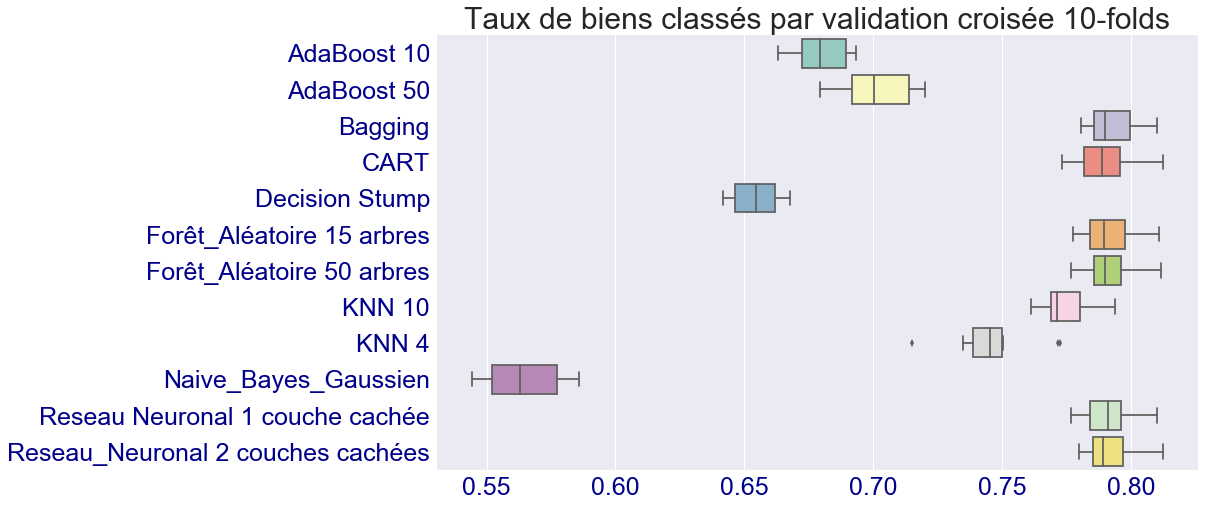

In [112]:
runClassifiers_bin(Liste, T_1_bin, Y_nbre_boites_par_sexe_bin, graphe = True)

Sur la base de la table T_1 binarisée des 5 codes ATC, on peut prédire le sexe prédominant parmi les consommateurs d'un médicament donné avec un taux de biens classés de 79 %, qui est le plafont atteint par tous les algorithmes suivants : CART, réseaux de neurones (1 et 2 couches cachées), Bagging et les forêts aléatoires (15 et 50 arbres). Tous ont également la même AUC, de l'ordre de 0.85. Ces résultats de prédiction sont donc satisfaisants. Il s'avère que des résultats identiques sont obtenables après réduction de dimension à 20 attributs seulement, ou 50, au lieu des 1874 initiaux :

estimations par validation croisée 10 fold de Naive_Bayes_Gaussien :
Taux biens classés = 0.645 +/- 0.014
AUC = 0.674 +/- 0.015
Temps d'exécution = 0.312 secondes


estimations par validation croisée 10 fold de CART :
Taux biens classés = 0.787 +/- 0.011
AUC = 0.851 +/- 0.012
Temps d'exécution = 1.700 secondes


estimations par validation croisée 10 fold de Decision Stump :
Taux biens classés = 0.652 +/- 0.007
AUC = 0.541 +/- 0.004
Temps d'exécution = 0.300 secondes


estimations par validation croisée 10 fold de Reseau Neuronal 1 couche cachée :
Taux biens classés = 0.710 +/- 0.008
AUC = 0.766 +/- 0.012
Temps d'exécution = 37.290 secondes


estimations par validation croisée 10 fold de Reseau_Neuronal 2 couches cachées :
Taux biens classés = 0.724 +/- 0.011
AUC = 0.778 +/- 0.013
Temps d'exécution = 49.152 secondes


estimations par validation croisée 10 fold de Bagging :
Taux biens classés = 0.788 +/- 0.010
AUC = 0.854 +/- 0.012
Temps d'exécution = 12.621 secondes


estimations par va

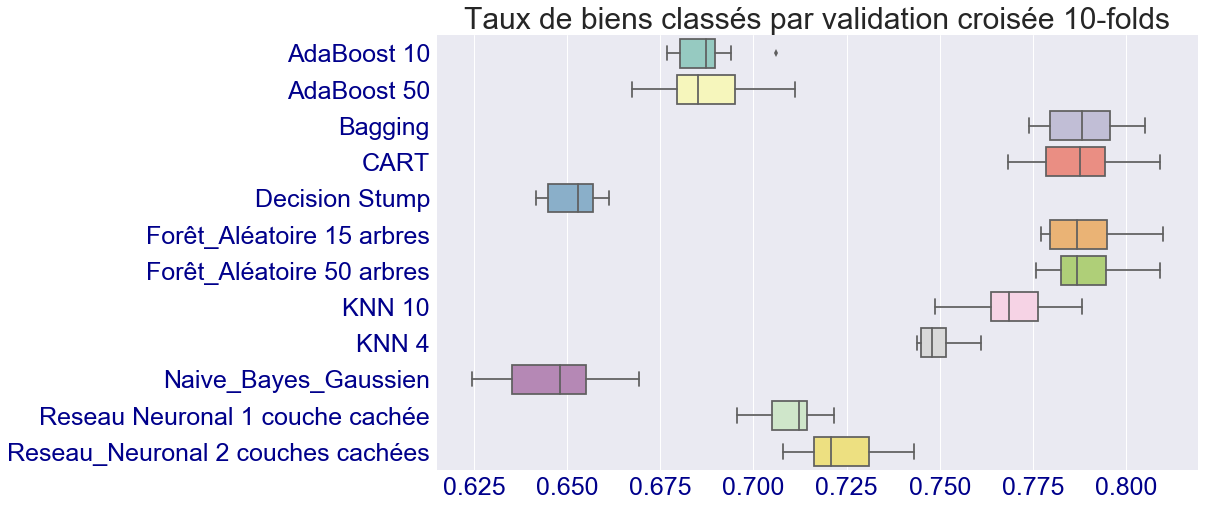

In [27]:
runClassifiers_bin(Liste, T_1_svd_20, Y_nbre_boites_par_sexe_bin, graphe = True)

estimations par validation croisée 10 fold de Naive_Bayes_Gaussien :
Taux biens classés = 0.586 +/- 0.014
AUC = 0.710 +/- 0.016
Temps d'exécution = 0.556 secondes


estimations par validation croisée 10 fold de CART :
Taux biens classés = 0.788 +/- 0.012
AUC = 0.851 +/- 0.012
Temps d'exécution = 4.946 secondes


estimations par validation croisée 10 fold de Decision Stump :
Taux biens classés = 0.652 +/- 0.007
AUC = 0.541 +/- 0.004
Temps d'exécution = 0.600 secondes


estimations par validation croisée 10 fold de Reseau Neuronal 1 couche cachée :
Taux biens classés = 0.753 +/- 0.009
AUC = 0.817 +/- 0.011
Temps d'exécution = 41.569 secondes


estimations par validation croisée 10 fold de Reseau_Neuronal 2 couches cachées :
Taux biens classés = 0.750 +/- 0.009
AUC = 0.814 +/- 0.011
Temps d'exécution = 50.793 secondes


estimations par validation croisée 10 fold de Bagging :
Taux biens classés = 0.790 +/- 0.009
AUC = 0.855 +/- 0.013
Temps d'exécution = 34.273 secondes


estimations par va

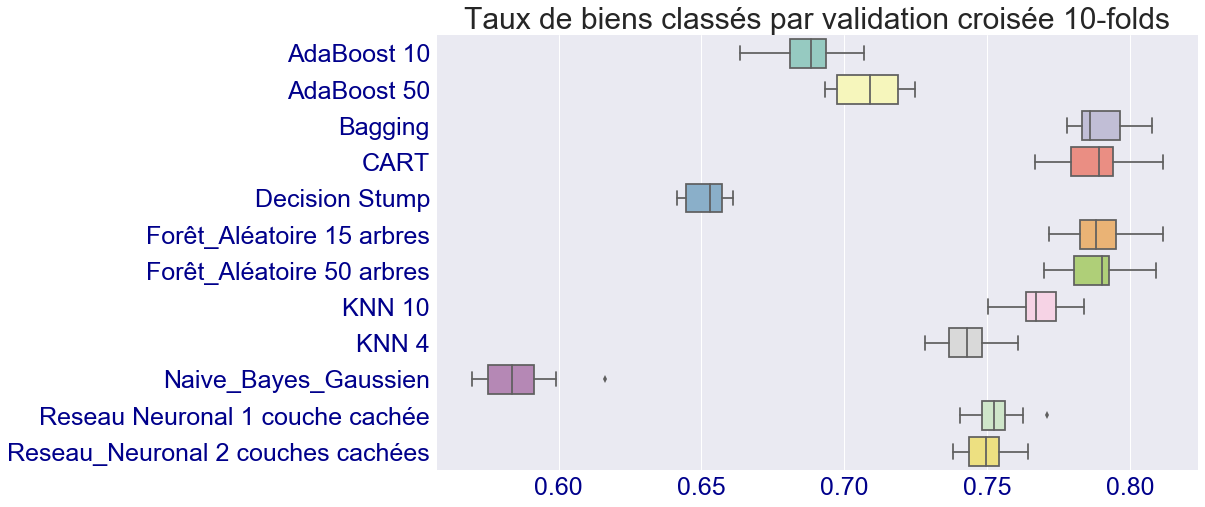

In [113]:
runClassifiers_bin(Liste, T_1_svd_50, Y_nbre_boites_par_sexe_bin, graphe = True)

La prédiction atteint dans le meilleur des cas les 79 % également.

### III.1.2 Prédiction du sexe sur la base des principes actifs

On effectue une prédiction du sexe prédominant parmi les consommateurs d'un médicament donné, sur la base des principes actifs de chaque médicament :

estimations par validation croisée 10 fold de Naive_Bayes_Gaussien :
Taux biens classés = 0.520 +/- 0.013
AUC = 0.681 +/- 0.014
Temps d'exécution = 0.512 secondes


estimations par validation croisée 10 fold de CART :
Taux biens classés = 0.751 +/- 0.012
AUC = 0.810 +/- 0.013
Temps d'exécution = 6.928 secondes


estimations par validation croisée 10 fold de Decision Stump :
Taux biens classés = 0.650 +/- 0.010
AUC = 0.539 +/- 0.006
Temps d'exécution = 0.744 secondes


estimations par validation croisée 10 fold de Reseau Neuronal 1 couche cachée :
Taux biens classés = 0.697 +/- 0.010
AUC = 0.705 +/- 0.016
Temps d'exécution = 42.756 secondes


estimations par validation croisée 10 fold de Reseau_Neuronal 2 couches cachées :
Taux biens classés = 0.695 +/- 0.011
AUC = 0.702 +/- 0.018
Temps d'exécution = 59.992 secondes


estimations par validation croisée 10 fold de Bagging :
Taux biens classés = 0.752 +/- 0.013
AUC = 0.813 +/- 0.014
Temps d'exécution = 64.206 secondes


estimations par va

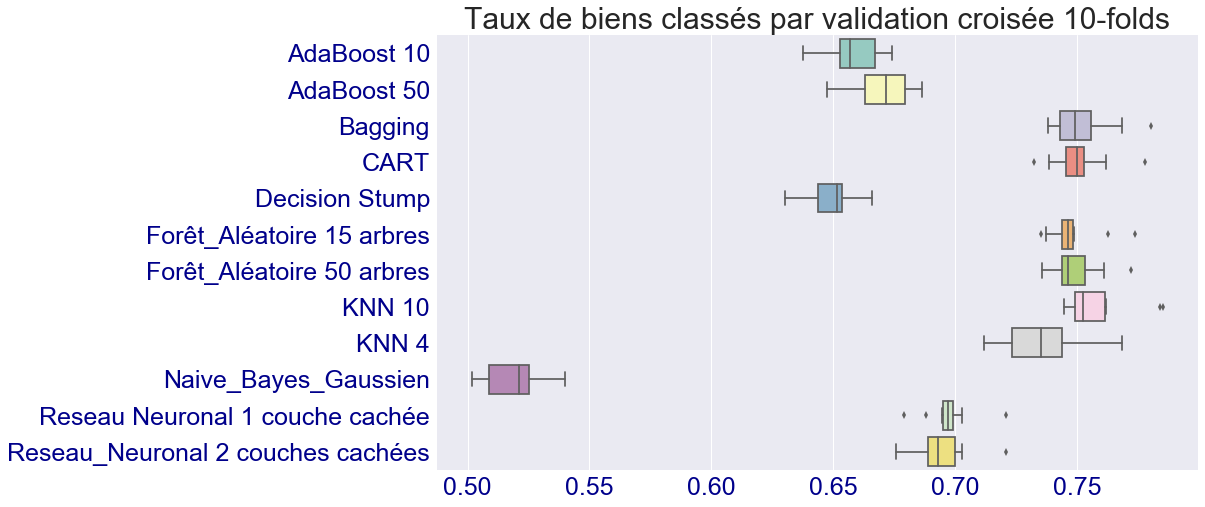

In [31]:
runClassifiers_bin(Liste, T_3_svd_50,  Y_nbre_boites_par_sexe_bin, graphe = True)

La prédiction atteint péniblement les 75 % sur la bases des principes actifs.

### III.1.3 Prédiction sur la fusion des tables

On teste enfin avec les tables T_4 et T_5 :

estimations par validation croisée 10 fold de Naive_Bayes_Gaussien :
Taux biens classés = 0.652 +/- 0.014
AUC = 0.753 +/- 0.018
Temps d'exécution = 0.928 secondes


estimations par validation croisée 10 fold de CART :
Taux biens classés = 0.789 +/- 0.009
AUC = 0.850 +/- 0.009
Temps d'exécution = 14.945 secondes


estimations par validation croisée 10 fold de Decision Stump :
Taux biens classés = 0.652 +/- 0.007
AUC = 0.541 +/- 0.004
Temps d'exécution = 1.400 secondes


estimations par validation croisée 10 fold de Reseau Neuronal 1 couche cachée :
Taux biens classés = 0.763 +/- 0.011
AUC = 0.826 +/- 0.012
Temps d'exécution = 65.575 secondes


estimations par validation croisée 10 fold de Reseau_Neuronal 2 couches cachées :
Taux biens classés = 0.766 +/- 0.012
AUC = 0.826 +/- 0.012
Temps d'exécution = 69.764 secondes


estimations par validation croisée 10 fold de Bagging :
Taux biens classés = 0.791 +/- 0.009
AUC = 0.855 +/- 0.010
Temps d'exécution = 93.314 secondes


estimations par v

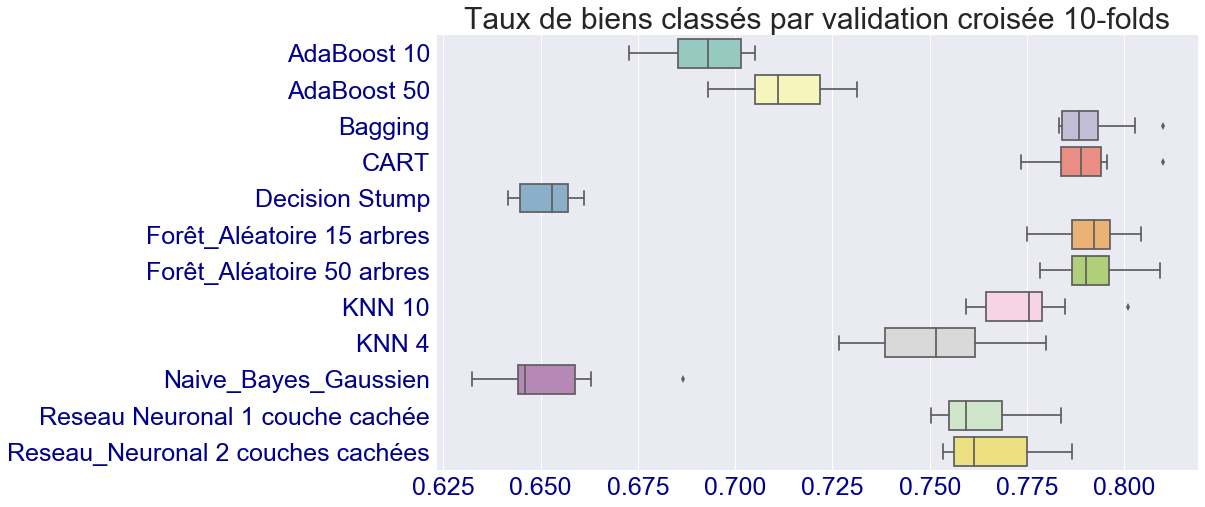

In [29]:
runClassifiers_bin(Liste, T_4_svd_50, Y_nbre_boites_par_sexe_bin, graphe = True)

In [114]:
runClassifiers_bin(Liste, T_5, Y_nbre_boites_par_sexe_bin, graphe = False)

estimations par validation croisée 10 fold de Naive_Bayes_Gaussien :
Taux biens classés = 0.626 +/- 0.018
AUC = 0.717 +/- 0.022
Temps d'exécution = 0.689 secondes


estimations par validation croisée 10 fold de CART :
Taux biens classés = 0.789 +/- 0.011
AUC = 0.848 +/- 0.009
Temps d'exécution = 6.413 secondes


estimations par validation croisée 10 fold de Decision Stump :
Taux biens classés = 0.654 +/- 0.009
AUC = 0.544 +/- 0.006
Temps d'exécution = 0.696 secondes


estimations par validation croisée 10 fold de Reseau Neuronal 1 couche cachée :
Taux biens classés = 0.762 +/- 0.009
AUC = 0.821 +/- 0.011
Temps d'exécution = 46.111 secondes


estimations par validation croisée 10 fold de Reseau_Neuronal 2 couches cachées :
Taux biens classés = 0.761 +/- 0.010
AUC = 0.822 +/- 0.012
Temps d'exécution = 65.123 secondes


estimations par validation croisée 10 fold de Bagging :
Taux biens classés = 0.790 +/- 0.008
AUC = 0.854 +/- 0.010
Temps d'exécution = 42.611 secondes


estimations par va

On observe que, malgré la considération simultanée des description de médicaments par codes ATC et principes actifs, **la base des 80 % des biens classés estimé par validation croisée n'est pas atteinte**. Le résultat de cette démarche est donc décevant. Un point qui pourrait être important serait de trouver une méthode afin d'intégrer le mieux possible les proportions de chaque principe actif dans les médicaments, afin d'améliorer le taux de biens classés. Un second point à développer est d'effectuer l'apprentissage d'un classifieur probabiliste sur la base du vecteur Y_nbre_boites_par_sexe_proba, pour ensuite construire un classifieur déterministe avec un seuil de 0.5 (ou peut-être un seuil à calibrer).

## III.2 Prédiction de la tranche d'âge



In [115]:
Liste = {
    
    'RF': RandomForestClassifier(n_estimators=50),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'CART': DecisionTreeClassifier(criterion='gini'),
    'ID3': DecisionTreeClassifier(criterion='entropy'),
    'DST': DecisionTreeClassifier(max_depth=1),
    'MLP': MLPClassifier(hidden_layer_sizes=(20, 10), alpha=0.001, max_iter=200)
}

In [116]:
from sklearn.metrics import roc_auc_score, average_precision_score, silhouette_score, zero_one_loss, hamming_loss, make_scorer, accuracy_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import cross_val_score, KFold


def runClassifiers2(clfs, X, Y, graphe = True) :
    kf = KFold(n_splits=10, shuffle=True, random_state=0)
       
    cv_acc = {}
    loss ={}
    t0 = {}
    t1 = {}   
    
    for i in clfs:
        t0[i] = time.time()
        clf = clfs[i] 
        clf2 = clfs[i]
        clf2.fit(X,Y)
        score = accuracy_score(Y,clf2.predict(X))
        cv_acc[i] =  cross_val_score(clf, X, Y, cv=kf, scoring = make_scorer(accuracy_score, greater_is_better= True) )      
        t1[i] = time.time()
        print("Taux de biens classés estimé par validation croisée 10 fold de {0} = {1:.3f} +/- {2:.3f} ".format(i, np.mean(cv_acc[i]), np.std(cv_acc[i])))
        print("Taux de biens classés pour {0} = {1:.3f} ".format(i, score))
        print("Temps d'exécution = {0:.3f} secondes".format(t1[i] - t0[i]))
        print('\n')
        
    if graphe:
        cv_acc_df = pd.DataFrame.from_dict(cv_acc)
        
        plt.figure(figsize=(30, 8))
        ax1 = plt.subplot(121)
        ax1 = sns.boxplot(data = cv_acc_df, palette="Set3", orient = "h")
        ax1.tick_params(labelsize = 25, colors='darkblue')
        ax1.set_title("Taux de biens classés estimé par validation croisée 10-folds", fontsize = 30)
        plt.show()

On commence par estimer le taux de biens classés pour un ensemble d'algorithmes construits sur la classification ATC binarisée :

Taux de biens classés estimé par validation croisée 10 fold de RF = 0.814 +/- 0.010 
Taux de biens classés pour RF = 0.839 
Temps d'exécution = 140.484 secondes


Taux de biens classés estimé par validation croisée 10 fold de KNN = 0.803 +/- 0.010 
Taux de biens classés pour KNN = 0.827 
Temps d'exécution = 212.797 secondes


Taux de biens classés estimé par validation croisée 10 fold de CART = 0.806 +/- 0.011 
Taux de biens classés pour CART = 0.830 
Temps d'exécution = 57.758 secondes


Taux de biens classés estimé par validation croisée 10 fold de ID3 = 0.806 +/- 0.011 
Taux de biens classés pour ID3 = 0.830 
Temps d'exécution = 59.658 secondes


Taux de biens classés estimé par validation croisée 10 fold de DST = 0.639 +/- 0.010 
Taux de biens classés pour DST = 0.639 
Temps d'exécution = 16.413 secondes


Taux de biens classés estimé par validation croisée 10 fold de MLP = 0.810 +/- 0.014 
Taux de biens classés pour MLP = 0.839 
Temps d'exécution = 184.290 secondes




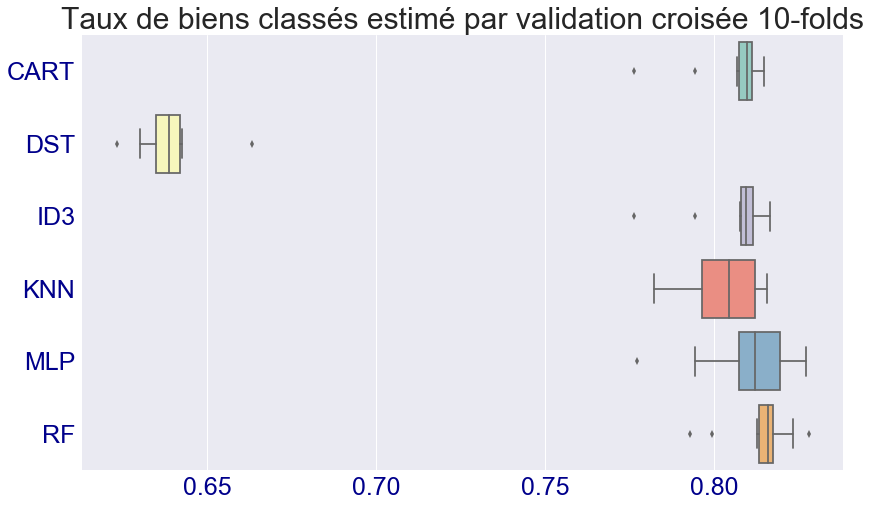

In [96]:
runClassifiers2(Liste,T_1_bin,Y_nbre_boites_par_age_bin)

Les classifieurs obtenus ont de très bons résultats, avec des taux de biens classés estimé par validation croisée supérieurs à 80 % pour la plupart (à comparer avec le classifieur mettant au hasard une des 3 valeurs en sortie à 1 et les deux autres à 0, qui affiche un taux théorique de 33 % de biens classés). On obtient également de bon résultats après réduction de dimension, avec un gain notable en temps de calcul :

Taux de biens classés estimé par validation croisée 10 fold de RF = 0.812 +/- 0.009 
Taux de biens classés pour RF = 0.835 
Temps d'exécution = 18.731 secondes


Taux de biens classés estimé par validation croisée 10 fold de KNN = 0.802 +/- 0.011 
Taux de biens classés pour KNN = 0.817 
Temps d'exécution = 1.375 secondes


Taux de biens classés estimé par validation croisée 10 fold de CART = 0.803 +/- 0.010 
Taux de biens classés pour CART = 0.824 
Temps d'exécution = 2.307 secondes


Taux de biens classés estimé par validation croisée 10 fold de ID3 = 0.804 +/- 0.010 
Taux de biens classés pour ID3 = 0.824 
Temps d'exécution = 3.800 secondes


Taux de biens classés estimé par validation croisée 10 fold de DST = 0.639 +/- 0.010 
Taux de biens classés pour DST = 0.639 
Temps d'exécution = 0.399 secondes


Taux de biens classés estimé par validation croisée 10 fold de MLP = 0.752 +/- 0.015 
Taux de biens classés pour MLP = 0.759 
Temps d'exécution = 48.088 secondes




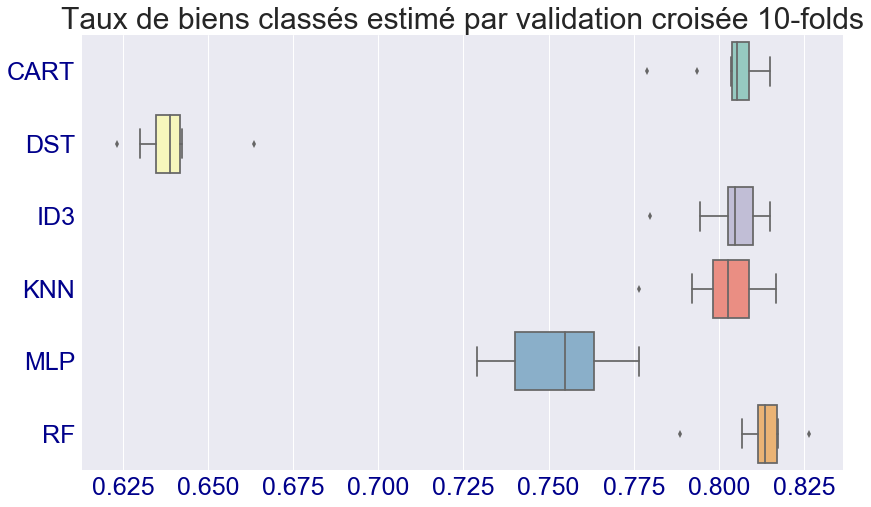

In [97]:
runClassifiers2(Liste,T_1_svd_50,Y_nbre_boites_par_age_bin)

La considération de 50 vecteurs singuliers et d'une sortie à 3 modalités améliore les performances, qui montent à 82,5 % :

Taux de biens classés estimé par validation croisée 10 fold de RF = 0.827 +/- 0.009 
Taux de biens classés pour RF = 0.853 
Temps d'exécution = 14.631 secondes


Taux de biens classés estimé par validation croisée 10 fold de KNN = 0.812 +/- 0.011 
Taux de biens classés pour KNN = 0.825 
Temps d'exécution = 1.300 secondes


Taux de biens classés estimé par validation croisée 10 fold de CART = 0.826 +/- 0.010 
Taux de biens classés pour CART = 0.853 
Temps d'exécution = 1.956 secondes


Taux de biens classés estimé par validation croisée 10 fold de ID3 = 0.825 +/- 0.010 
Taux de biens classés pour ID3 = 0.853 
Temps d'exécution = 2.863 secondes


Taux de biens classés estimé par validation croisée 10 fold de DST = 0.639 +/- 0.010 
Taux de biens classés pour DST = 0.639 
Temps d'exécution = 0.363 secondes


Taux de biens classés estimé par validation croisée 10 fold de MLP = 0.784 +/- 0.011 
Taux de biens classés pour MLP = 0.787 
Temps d'exécution = 40.895 secondes




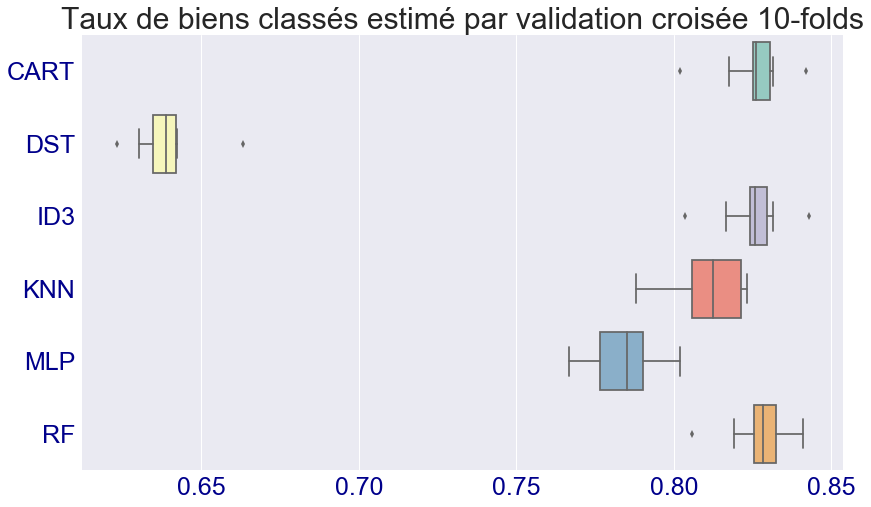

In [117]:
runClassifiers2(Liste,T_1_svd_50,Y_nbre_boites_par_age_3)

Des résultats très légèrement plus faibles sont obtenus à partir de la table des principes actifs binarisée seule :

Taux de biens classés estimé par validation croisée 10 fold de RF = 0.751 +/- 0.008 
Taux de biens classés pour RF = 0.761 
Temps d'exécution = 24.295 secondes


Taux de biens classés estimé par validation croisée 10 fold de KNN = 0.783 +/- 0.012 
Taux de biens classés pour KNN = 0.825 
Temps d'exécution = 1.614 secondes


Taux de biens classés estimé par validation croisée 10 fold de CART = 0.738 +/- 0.033 
Taux de biens classés pour CART = 0.762 
Temps d'exécution = 3.806 secondes


Taux de biens classés estimé par validation croisée 10 fold de ID3 = 0.738 +/- 0.033 
Taux de biens classés pour ID3 = 0.762 
Temps d'exécution = 4.720 secondes


Taux de biens classés estimé par validation croisée 10 fold de DST = 0.639 +/- 0.010 
Taux de biens classés pour DST = 0.639 
Temps d'exécution = 0.440 secondes


Taux de biens classés estimé par validation croisée 10 fold de MLP = 0.548 +/- 0.100 
Taux de biens classés pour MLP = 0.474 
Temps d'exécution = 52.619 secondes




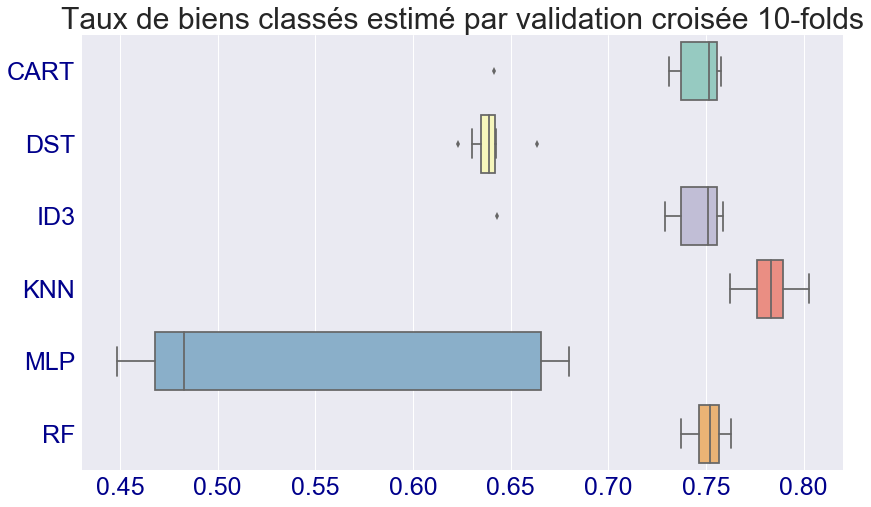

In [118]:
runClassifiers2(Liste,T_3_svd_50,Y_nbre_boites_par_age_bin)

On souhaite savoir si la fusion des deux tables améliore cette prédiction : Il s'avère malheureusement que non.

Taux de biens classés estimé par validation croisée 10 fold de RF = 0.818 +/- 0.010 
Taux de biens classés pour RF = 0.843 
Temps d'exécution = 29.308 secondes


Taux de biens classés estimé par validation croisée 10 fold de KNN = 0.807 +/- 0.010 
Taux de biens classés pour KNN = 0.832 
Temps d'exécution = 2.829 secondes


Taux de biens classés estimé par validation croisée 10 fold de CART = 0.807 +/- 0.010 
Taux de biens classés pour CART = 0.833 
Temps d'exécution = 5.518 secondes


Taux de biens classés estimé par validation croisée 10 fold de ID3 = 0.806 +/- 0.010 
Taux de biens classés pour ID3 = 0.833 
Temps d'exécution = 8.351 secondes


Taux de biens classés estimé par validation croisée 10 fold de DST = 0.639 +/- 0.010 
Taux de biens classés pour DST = 0.639 
Temps d'exécution = 0.806 secondes


Taux de biens classés estimé par validation croisée 10 fold de MLP = 0.769 +/- 0.010 
Taux de biens classés pour MLP = 0.773 
Temps d'exécution = 65.288 secondes




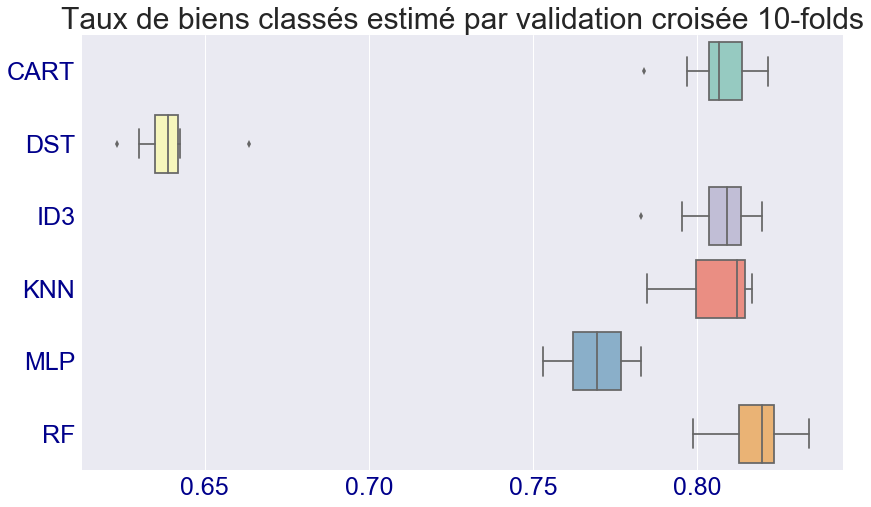

In [119]:
runClassifiers2(Liste,T_4_svd_50,Y_nbre_boites_par_age_bin)

Taux de biens classés estimé par validation croisée 10 fold de RF = 0.816 +/- 0.006 
Taux de biens classés pour RF = 0.853 
Temps d'exécution = 20.440 secondes


Taux de biens classés estimé par validation croisée 10 fold de KNN = 0.800 +/- 0.009 
Taux de biens classés pour KNN = 0.837 
Temps d'exécution = 1.317 secondes


Taux de biens classés estimé par validation croisée 10 fold de CART = 0.806 +/- 0.009 
Taux de biens classés pour CART = 0.837 
Temps d'exécution = 3.230 secondes


Taux de biens classés estimé par validation croisée 10 fold de ID3 = 0.805 +/- 0.010 
Taux de biens classés pour ID3 = 0.837 
Temps d'exécution = 5.552 secondes


Taux de biens classés estimé par validation croisée 10 fold de DST = 0.326 +/- 0.099 
Taux de biens classés pour DST = 0.294 
Temps d'exécution = 0.468 secondes


Taux de biens classés estimé par validation croisée 10 fold de MLP = 0.747 +/- 0.011 
Taux de biens classés pour MLP = 0.751 
Temps d'exécution = 64.048 secondes




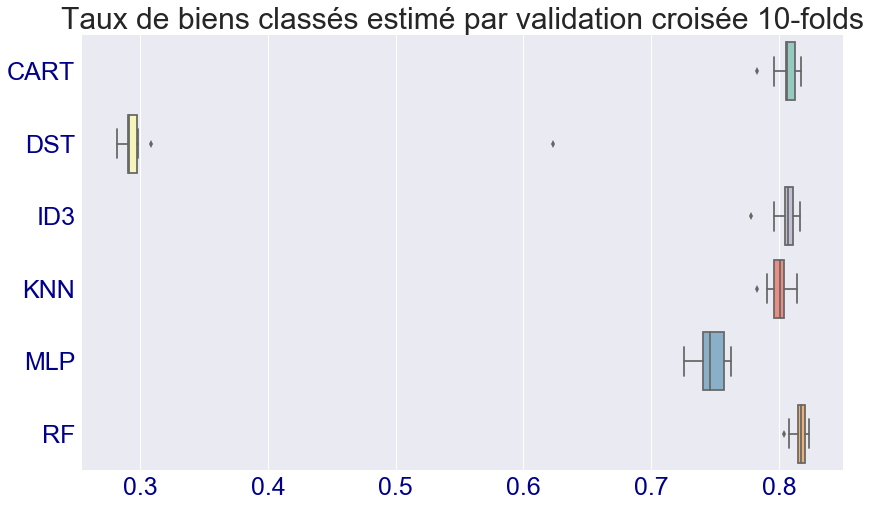

In [103]:
runClassifiers2(Liste,T_5,Y_nbre_boites_par_age_bin)

Taux de biens classés estimé par validation croisée 10 fold de RF = 0.830 +/- 0.009 
Taux de biens classés pour RF = 0.863 
Temps d'exécution = 16.067 secondes


Taux de biens classés estimé par validation croisée 10 fold de KNN = 0.811 +/- 0.009 
Taux de biens classés pour KNN = 0.844 
Temps d'exécution = 1.300 secondes


Taux de biens classés estimé par validation croisée 10 fold de CART = 0.826 +/- 0.009 
Taux de biens classés pour CART = 0.863 
Temps d'exécution = 2.888 secondes


Taux de biens classés estimé par validation croisée 10 fold de ID3 = 0.825 +/- 0.009 
Taux de biens classés pour ID3 = 0.863 
Temps d'exécution = 3.618 secondes


Taux de biens classés estimé par validation croisée 10 fold de DST = 0.639 +/- 0.010 
Taux de biens classés pour DST = 0.639 
Temps d'exécution = 0.396 secondes


Taux de biens classés estimé par validation croisée 10 fold de MLP = 0.786 +/- 0.010 
Taux de biens classés pour MLP = 0.782 
Temps d'exécution = 45.537 secondes




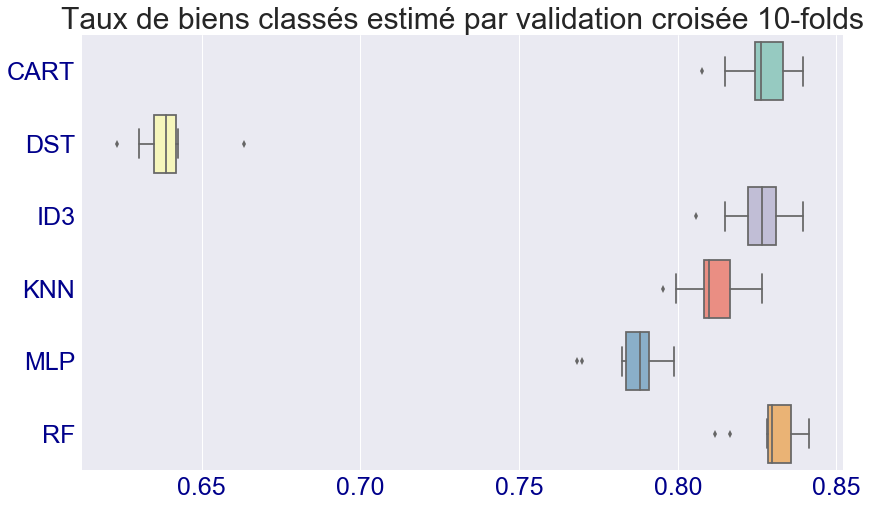

In [120]:
runClassifiers2(Liste,T_5,Y_nbre_boites_par_age_3)